In [1]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
import sklearn.utils
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

from collections import defaultdict
import math
import scikits.bootstrap as boot
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion
from sklearn.cross_validation import LeaveOneOut
from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import documents2feature_vectors, get_features, attacker_profile
from prediction_utils.configure import configure
from prediction_utils.test_svm import train_svm, top_coefficients
from prediction_utils.plotting import attacker_plot

/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
constraints = ['constraintA+B', 'constraintB']
constraint = constraints[0]
suffix = ''

# Load Data

In [3]:
user_features, ARGS = configure(constraint, suffix)
documents = []
with open('/scratch/wiki_dumps/paired_conversations/%s/data/all%s.json'%(constraint, suffix)) as f:
    ind = 0
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        documents.append((conversation, clss, conv_id)) 

random.shuffle(documents)
matched_pairs = []
title_dic = defaultdict(list)
for ind, doc in enumerate(documents):
    conversation, clss, conv_id = doc
    title_dic[conversation['action_feature'][0]['page_title']].append(ind)
matched_pairs = list(title_dic.values())
print('Number of folds: ', len(matched_pairs))

Number of folds:  794


# Testing on Features

In [4]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('Conversational Features Only: ')
conv_only_scores = train_svm(X, y, 0.05, matched_pairs)

user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('BOW Features Only: ')
bow_scores = train_svm(X, y, 0.0002, matched_pairs)

user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Questions=True, User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('User Features Only: ')
user_only_scores = train_svm(X, y, 0.3, matched_pairs)

print('Significance Test: ')
scipy.stats.wilcoxon(bow_scores, conv_only_scores)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Conversational Features Only: 
0.580 +/-0.011


/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BOW Features Only: 
0.554 +/-0.011


/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


User Features Only: 
0.535 +/-0.010
Significance Test: 


WilcoxonResult(statistic=44558.5, pvalue=0.05500199192609119)

# Top 20 Coefficients of Conversational Features

In [6]:
classifier = svm.LinearSVC(C=0.05)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names, 20)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
top_pos[::-1]

['toxicity_entropy',
 'max_time_gap',
 'min_nouns_over_tokens',
 'max_polarity_gap',
 'question_type4',
 'max_len',
 'min_len',
 'avg_len',
 'question_type0',
 'frac. negative_reply',
 'consecutive_negative',
 'has_content_words_repeat',
 'user_last_action_has_thank',
 'max_nouns_over_tokens',
 'user_last_action_has_greetings',
 'user_last_action_has_disagree',
 'question_type3',
 'question_type1',
 'has_question',
 'question_type6']

In [9]:
top_neg[::-1]

['max_toxicity',
 'user_last_action_has_consecutive_?or!',
 'mean_toxicity_gap',
 'nouns_over_tokens',
 'has_negative_reply',
 'positive_increase',
 'question_to_non_question',
 'positive reply to negative',
 'question_type5',
 "user_last_action_do/don't start",
 'stopwords_adoption',
 'user_last_action_verb start',
 'negative reply to positive',
 'reciprocity',
 'max_depth',
 'content_words_repeat',
 'content_words_adoption',
 'time_gap_entropy',
 'reply_entropy',
 'user_last_action_LEXICON_pron_you']

# Plots

Bad Total:
proportion_of_being_replied 813
proportion_of_utterance_over_all 769
total_length_of_utterance 822
maximum_toxicity 823
age 756
status 502
comments_on_all_talk_pages 733
edits_on_wikipedia_articles 743
history_toxicity 743
self_modification 0
other_modification 0
pron_you_usage 642
gratitude_usage 206
max_negativity 725
Good Total:
proportion_of_being_replied 849
proportion_of_utterance_over_all 787
total_length_of_utterance 852
maximum_toxicity 856
age 814
status 537
comments_on_all_talk_pages 776
edits_on_wikipedia_articles 765
history_toxicity 786
self_modification 0
other_modification 0
pron_you_usage 655
gratitude_usage 276
max_negativity 735


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


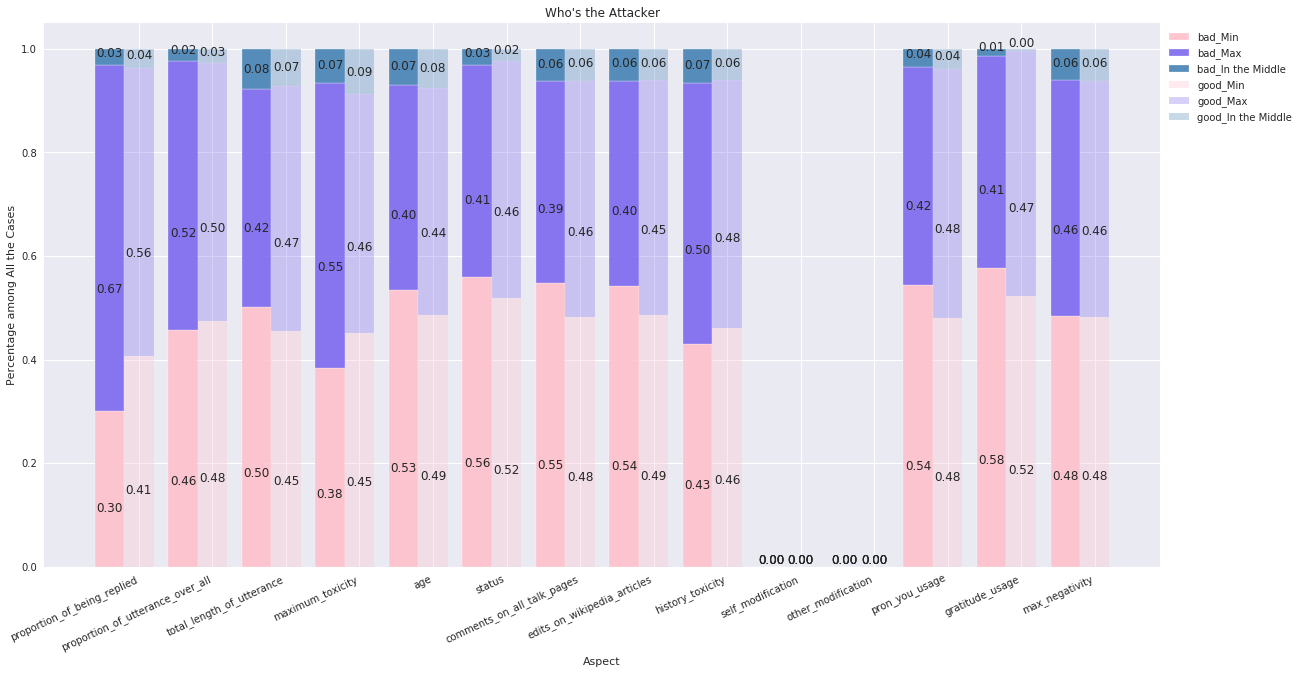

Test 1
proportion_of_being_replied
Average in Ggap:  0.406360424028
Average of Bgap:  0.30012300123
MannwhitneyuResult(statistic=308454.0, pvalue=3.0228344948628823e-06)


proportion_of_utterance_over_all
Average in Ggap:  0.475222363405
Average of Bgap:  0.457737321196
MannwhitneyuResult(statistic=297310.5, pvalue=0.24480478187407084)


total_length_of_utterance
Average in Ggap:  0.454225352113
Average of Bgap:  0.501216545012
MannwhitneyuResult(statistic=333717.0, pvalue=0.027198268772826231)


maximum_toxicity
Average in Ggap:  0.450934579439
Average of Bgap:  0.382746051033
MannwhitneyuResult(statistic=328225.0, pvalue=0.0023169814789341272)


age
Average in Ggap:  0.485257985258
Average of Bgap:  0.534391534392
MannwhitneyuResult(statistic=292574.0, pvalue=0.02587990043698123)


status
Average in Ggap:  0.519553072626
Average of Bgap:  0.559760956175
MannwhitneyuResult(statistic=129367.5, pvalue=0.097055171073138713)


comments_on_all_talk_pages
Average in Ggap:  0.481958762887
Av

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yiqing/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [5]:
attacker_profile_ASPECTS = ARGS[2]
attacker_plot(all_profiles, attacker_profile_ASPECTS)